In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from keras.layers import Dense,Dropout,GlobalAveragePooling2D,BatchNormalization
from  keras import Sequential
from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import gc
%matplotlib inline
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Context**

This is image data of Natural Scenes around the world.

**Content**

This Data contains around 25k images of size 150x150 distributed under 6 categories.
{'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 }

The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test and 7k in Prediction.
This data was initially published on https://datahack.analyticsvidhya.com by Intel to host a Image classification Challenge.

**Acknowledgements**

Thanks to https://datahack.analyticsvidhya.com for the challenge and Intel for the Data

Photo by Jan Böttinger on Unsplash

**Inspiration**

Want to build powerful Neural network that can classify these images with more accuracy.

In [2]:
train_dir = '../input/intel-image-classification/seg_train/seg_train/'
test_dir = '../input/intel-image-classification/seg_test/seg_test/'
pred_dir = '../input/intel-image-classification/seg_pred/seg_pred/'

In [3]:
os.listdir(train_dir)

['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']

In [4]:
album = pd.DataFrame(columns = ["id","label"])
dirs = ['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']
for direc in dirs:
    for file in os.listdir(train_dir + direc):
        album = album.append({"id":file,"label":direc},ignore_index = True)
album.head()

id     label
0  14986.jpg  mountain
1   3138.jpg  mountain
2   1700.jpg  mountain
3  16257.jpg  mountain
4   2863.jpg  mountain

In [5]:
test_album = pd.DataFrame(columns = ["id","label"])
dirs = ['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']
for direc in dirs:
    for file in os.listdir(test_dir + direc):
        test_album = test_album.append({"id":file,"label":direc},ignore_index = True)
test_album.head()

id     label
0  22608.jpg  mountain
1  23274.jpg  mountain
2  23775.jpg  mountain
3  22046.jpg  mountain
4  23436.jpg  mountain

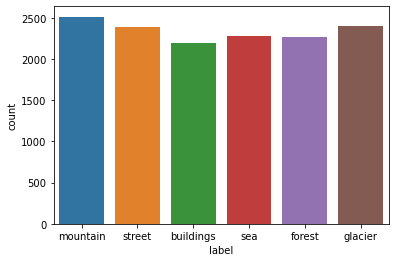

In [6]:
sns.countplot(x="label", data=album)

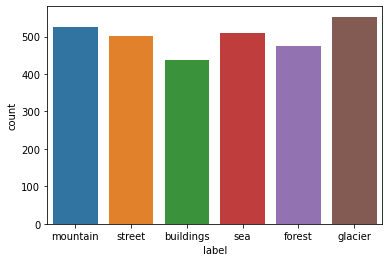

In [7]:
sns.countplot(x="label", data=test_album)

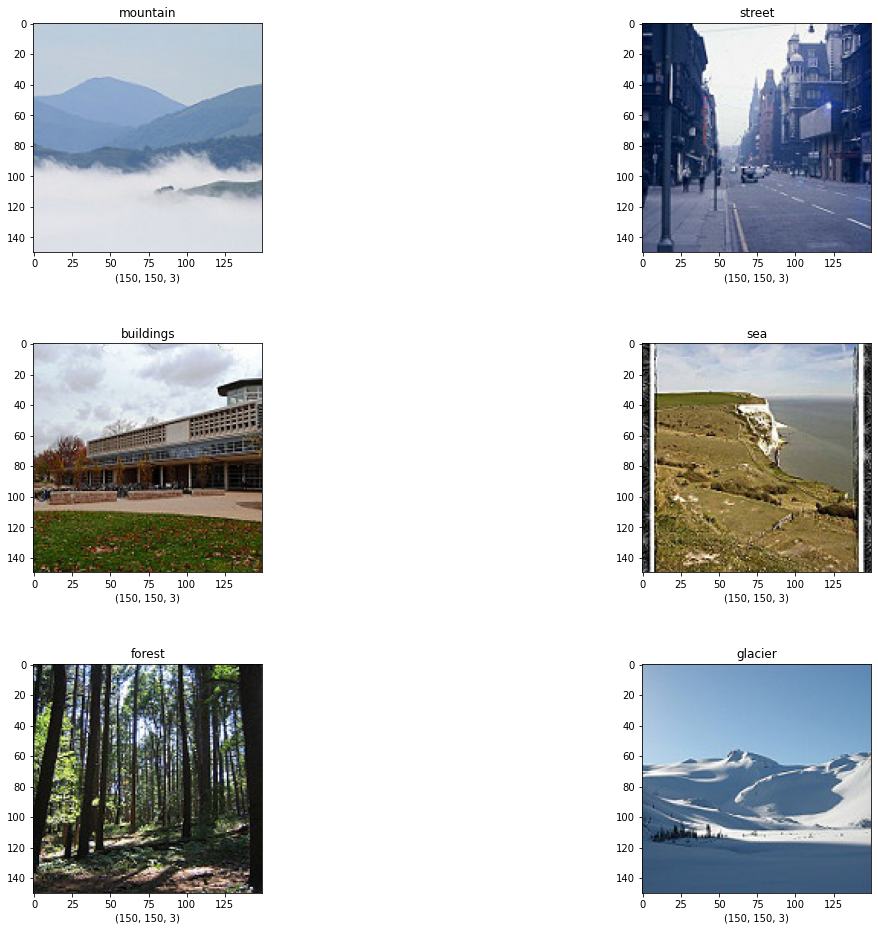

In [8]:
plt.figure(figsize = (20,16))
n = 0
for label in dirs:
    n += 1
    img = (album["id"].where(album["label"] == label).dropna()).iloc[0]
    plt.subplot(3,2,n)
    plt.subplots_adjust(hspace = 0.4,wspace = 0.2)
    path = train_dir + label + '/' + img
    plt.imshow(Image.open(path))
    plt.xlabel((img_to_array(Image.open(path))).shape)
    plt.title(label)
    
plt.show()

In [9]:
def generate(train_dir,test_dir):
    train_datagen = ImageDataGenerator(rescale=1./255,horizontal_flip=True,validation_split = 0.2)
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_gen = train_datagen.flow_from_directory(
      directory = train_dir,
      subset="training",
      target_size = (150,150),
      shuffle = True,
      class_mode = 'categorical',
      batch_size=500)
    
    val_gen = train_datagen.flow_from_directory(
      directory = train_dir,
      subset="validation",
      shuffle = True,
      class_mode = 'categorical',
      target_size=(150,150),
      batch_size=500)
    
    test_gen = test_datagen.flow_from_directory(
      directory = test_dir,
      shuffle = True,
      class_mode = 'categorical',
      target_size = (150,150),
      batch_size = 500)
    
    return train_gen,val_gen,test_gen

In [10]:
train_gen,valid_gen,test_gen = generate(train_dir,test_dir)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [11]:
from keras.applications import DenseNet121

In [12]:
def get_model(arch):
    base_model = arch(include_top = False,
                        input_shape = (150,150,3),
                        weights = "imagenet")
    base_model.trainable = False
    print("Length of Model: ",len(list((base_model.layers))))
    return base_model

In [13]:
def hypertune(train_gen,valid_gen,test_gen,arch = DenseNet121,lr = 0.005,m =128,n =512):    
    base_model = get_model(arch)
    gal = GlobalAveragePooling2D()(base_model.output)
    d1 = Dense(units = m,activation = 'relu')(gal)
    drop1 = Dropout(0.2)(d1)
    d2 = Dense(units = n,activation = 'relu')(drop1)
    drop2 = Dropout(0.4)(d2)
    bn = BatchNormalization()(drop2)
    output = Dense(units = 6,activation = "softmax")(bn)
    model = tf.keras.Model(inputs = base_model.input,outputs = output)
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = lr),loss = "categorical_crossentropy",metrics = ["categorical_accuracy"])
    history = model.fit(train_gen,validation_data = valid_gen,batch_size = 500,steps_per_epoch = 11230 // 500,epochs = 5)
    loss,acc = model.evaluate(test_gen)
    return [model,history]

In [14]:
def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('categorical_accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('categorical_accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [15]:
values = hypertune(train_gen,valid_gen,test_gen)
model = values[0]
history = values[1]

29089792/29084464 [==============================] - 0s 0us/step
Length of Model:  427
Epoch 1/5
22/22 [==============================] - 88s 4s/step - loss: 0.5276 - categorical_accuracy: 0.8184 - val_loss: 0.5806 - val_categorical_accuracy: 0.8502
Epoch 2/5
22/22 [==============================] - 27s 1s/step - loss: 0.3098 - categorical_accuracy: 0.8884 - val_loss: 0.3545 - val_categorical_accuracy: 0.8919
Epoch 3/5
22/22 [==============================] - 26s 1s/step - loss: 0.2663 - categorical_accuracy: 0.9003 - val_loss: 0.2998 - val_categorical_accuracy: 0.8941
Epoch 4/5
22/22 [==============================] - 27s 1s/step - loss: 0.2495 - categorical_accuracy: 0.9079 - val_loss: 0.2847 - val_categorical_accuracy: 0.8955
Epoch 5/5
6/6 [==============================] - 17s 3s/step - loss: 0.2515 - categorical_accuracy: 0.9130


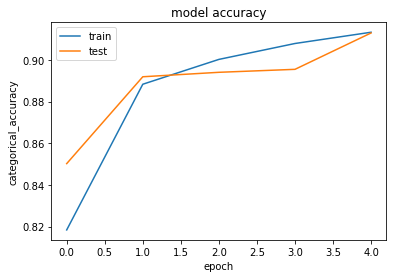

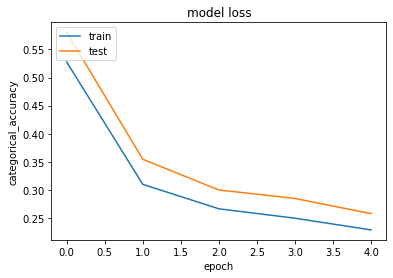

In [16]:
plot_history(history)

In [17]:
classes = list(train_gen.class_indices)
classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [18]:
x = img_to_array(Image.open('../input/intel-image-classification/seg_train/seg_train/street/1000.jpg'))
x = x/255
x = np.expand_dims(x,axis = 0)
x.shape
print(classes[np.argmax(model.predict(x))])

street


In [19]:
pred_album = pd.DataFrame(columns = ["id","label"])

In [20]:
for file in os.listdir(pred_dir):
    path = pred_dir + file
    x = img_to_array(Image.open(path))
    x = x/255
    x = np.expand_dims(x,axis = 0)
    pred = classes[np.argmax(model.predict(x))]
    pred_album = pred_album.append({"id":file,"label":pred},ignore_index = True)

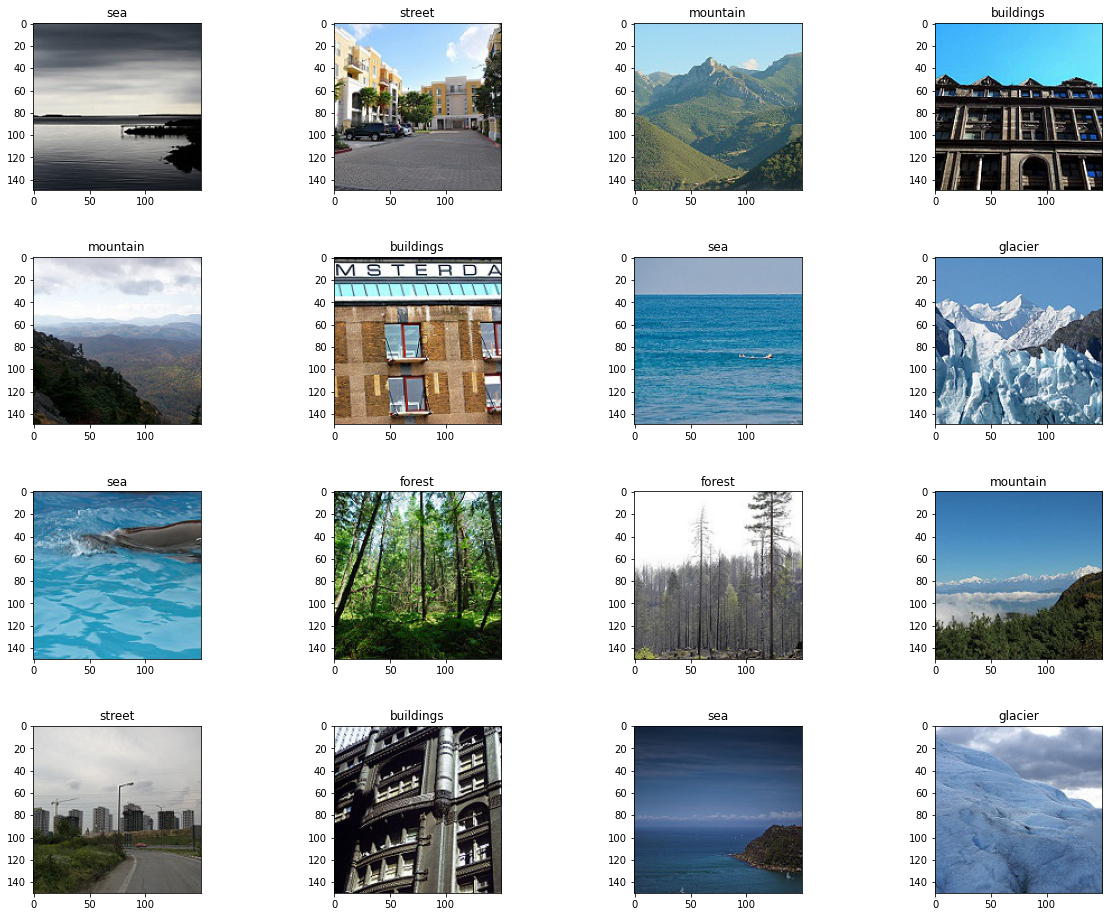

In [21]:
showcase = pred_album.iloc[:16,:]
plt.figure(figsize = (20,16))
n = 0
for image,label in zip(list(showcase["id"]),list(showcase["label"])):
    n += 1
    plt.subplot(4,4,n)
    plt.subplots_adjust(hspace= 0.4,wspace = 0.4)
    path = pred_dir + image
    plt.imshow(Image.open(path))
    plt.title('{}'.format(label))

In [22]:
pred_album.to_csv('answers.csv')

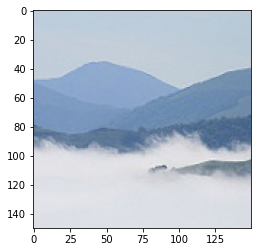

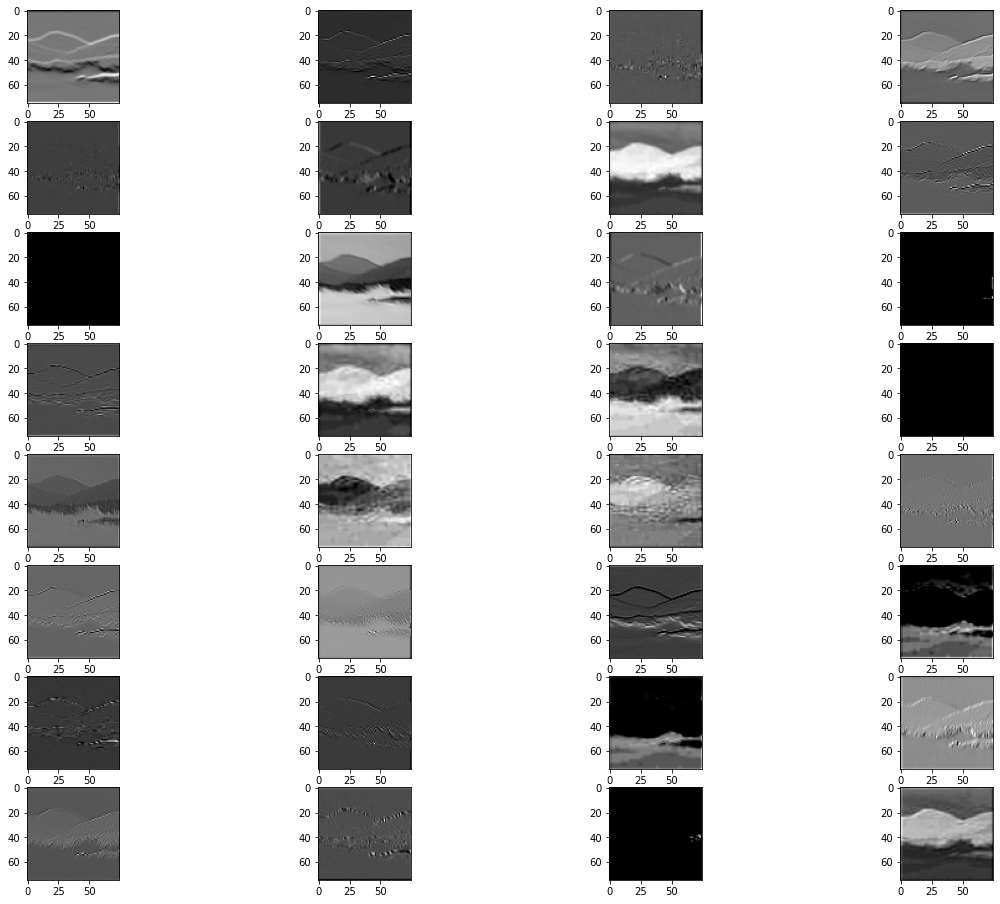

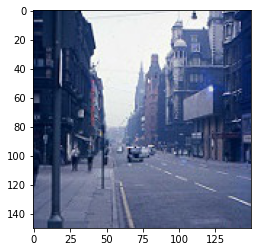

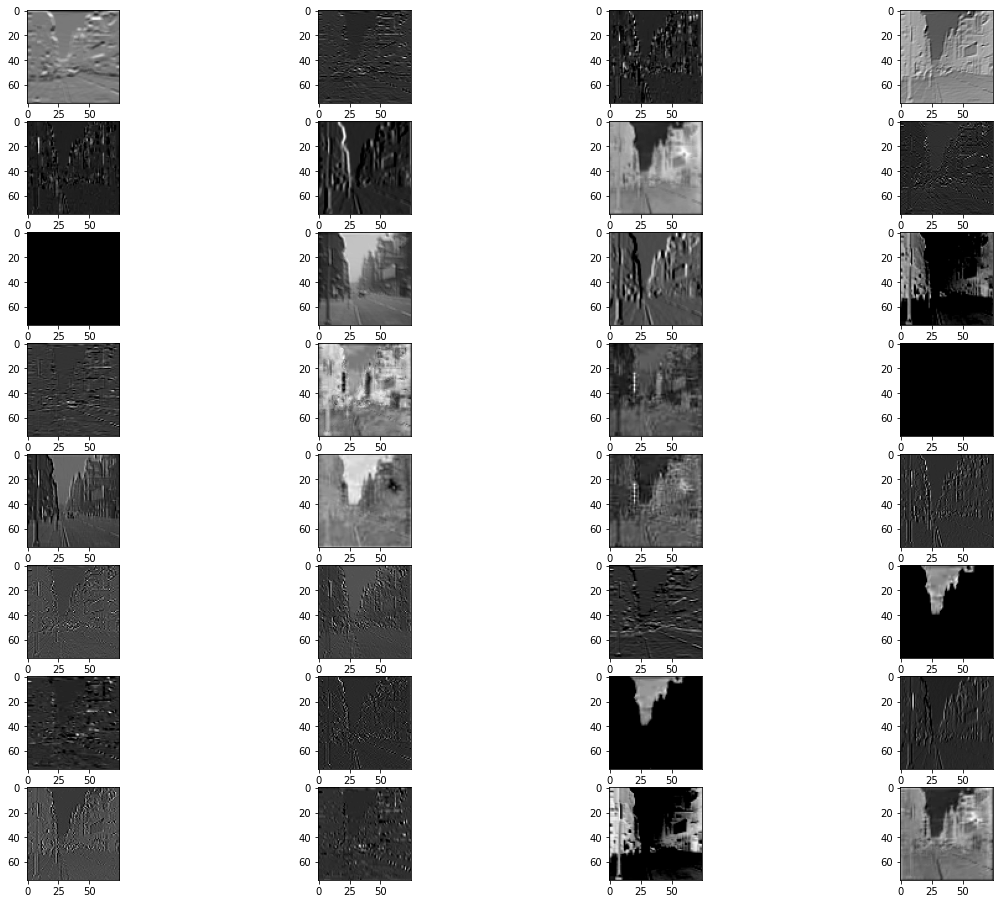

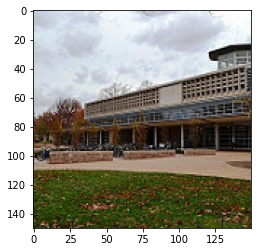

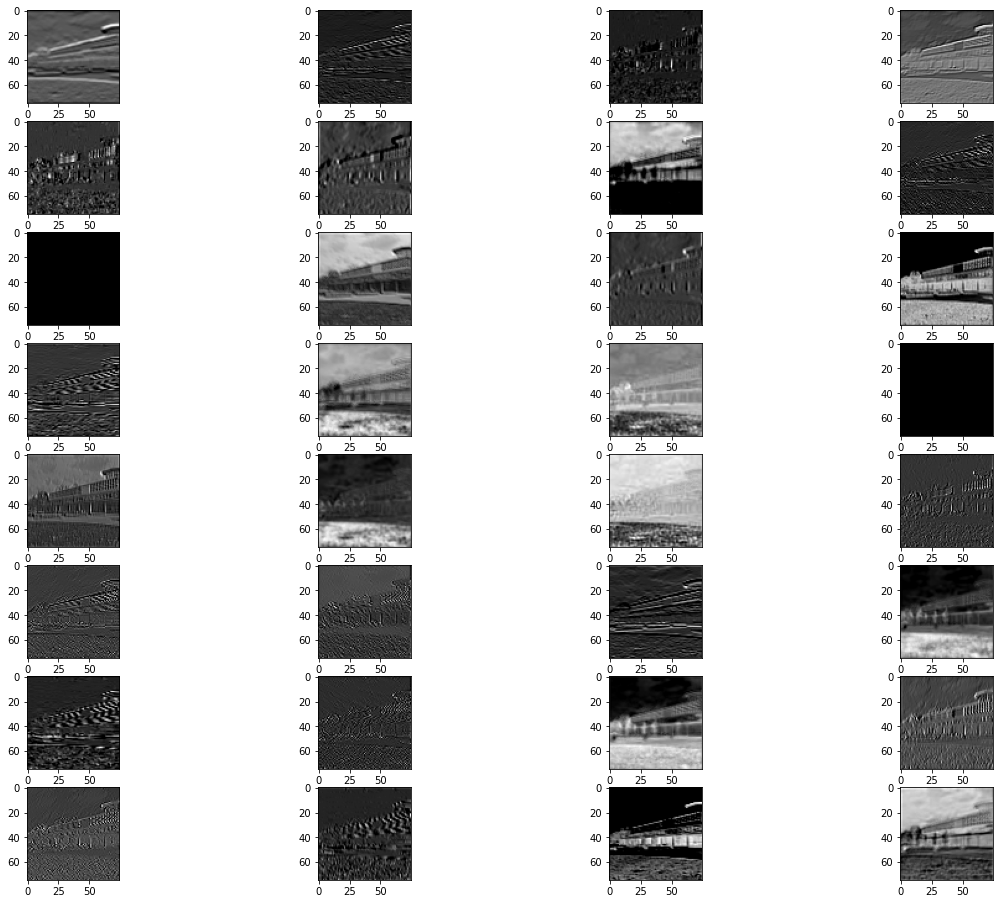

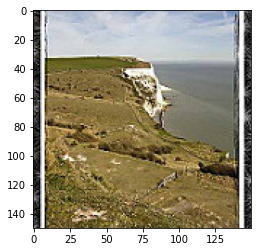

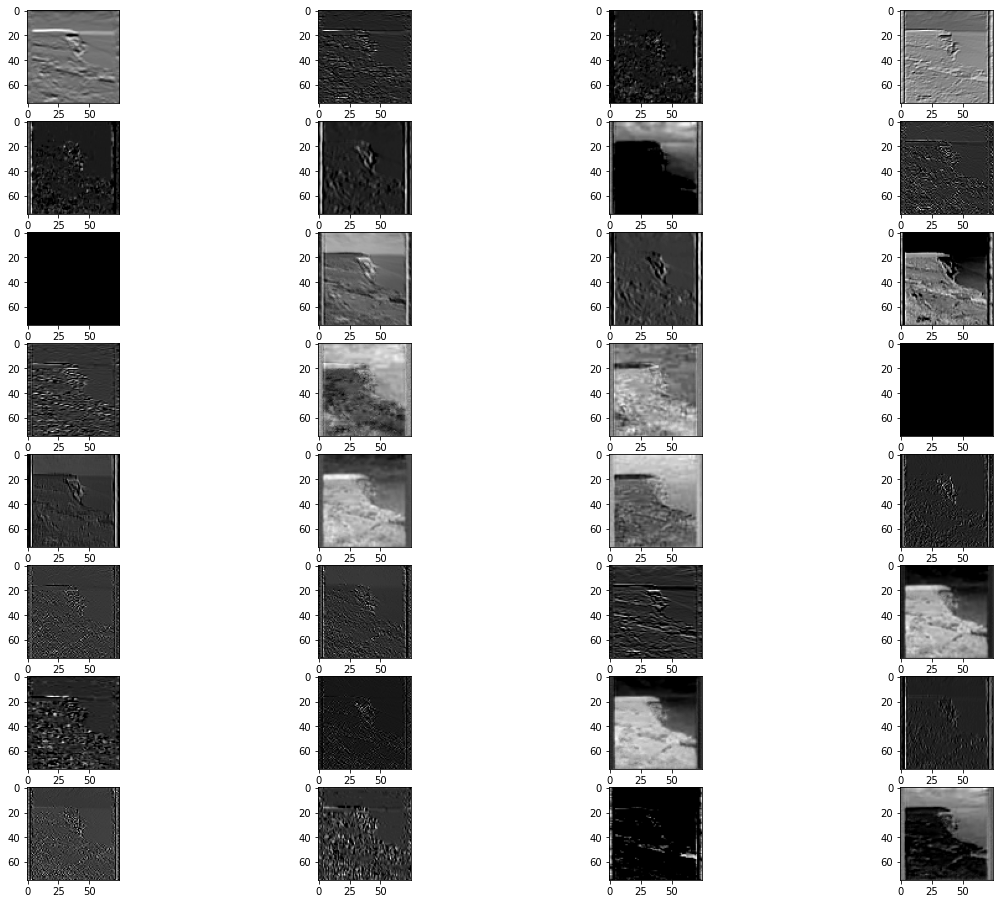

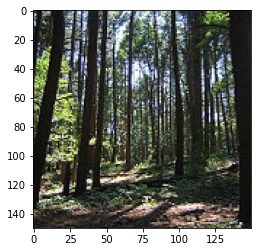

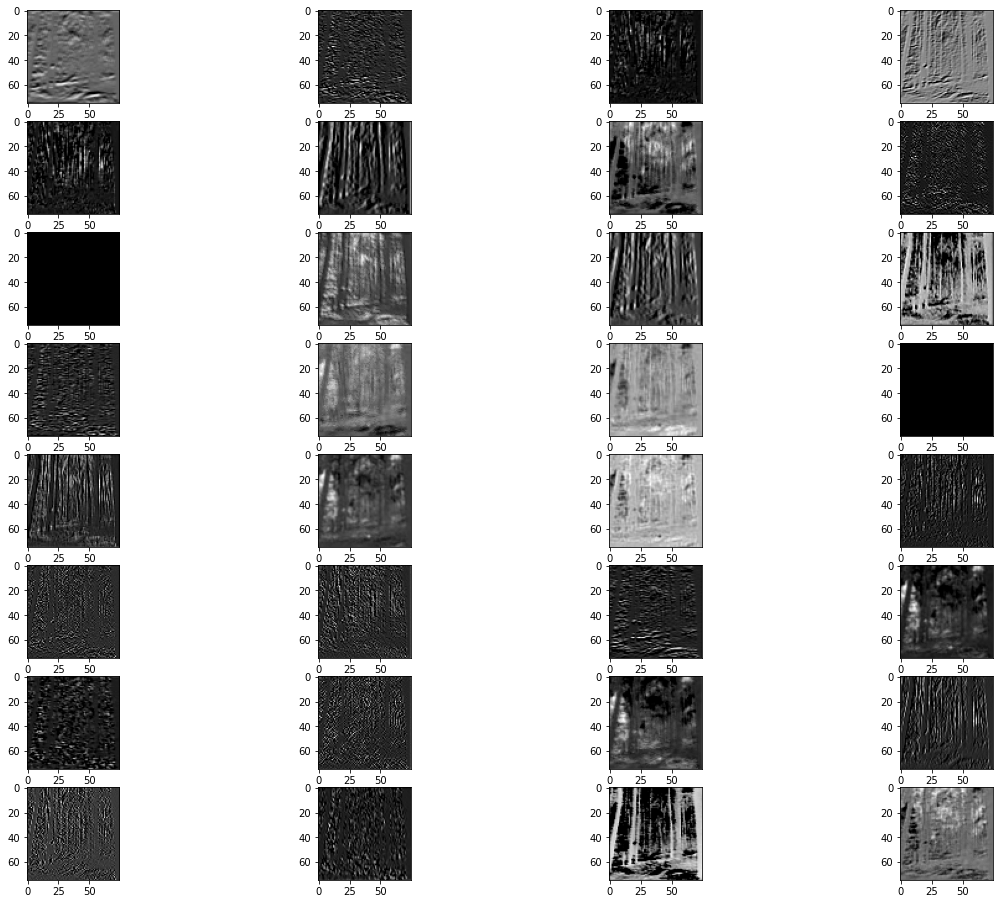

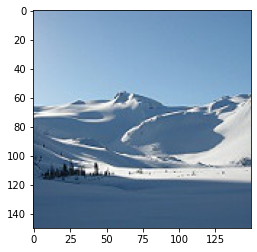

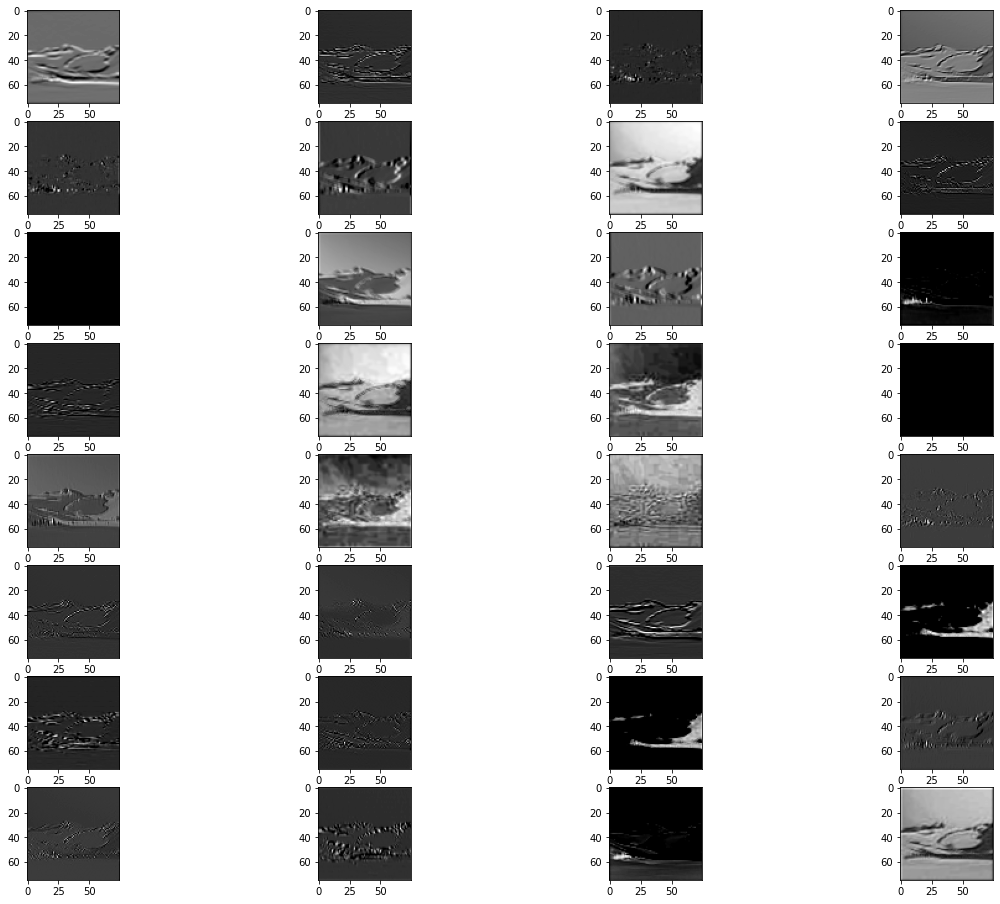

In [23]:
for label in dirs:
    file = (album["id"].where(album["label"] == label).dropna()).iloc[0]
    path = train_dir + label + '/' + file
    sample_img = load_img(path, target_size=(150,150,3))
    plt.imshow(sample_img)
    sample_img = np.expand_dims(sample_img, axis=0)
    sample_img = tf.keras.applications.densenet.preprocess_input(sample_img)
    extractor = tf.keras.Model(inputs = model.input,outputs = model.layers[4].output)
    feature_maps = extractor.predict(sample_img)
    plt.figure(figsize = (20,16))
    n = 0
    for i in range(32):
        n += 1
        plt.subplot(8,4,n)
        plt.subplots_adjust()
        # plot filter channel in grayscale
        plt.imshow(feature_maps[0, :, :, n-1], cmap='gray')
        # show the figure
    plt.show()